In [1]:
# import cmocean.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
#from salishsea_tools import viz_tools

%matplotlib inline

# graphics style
plt.style.use('seaborn-poster')
#plt.style.use(r"../../presentations/MEOPAR2022/meopar2022_matplotlibrc.template")
# Aggregated files path
agg_dir = Path('/data/sallen/MIDOSS/aggregated_spills_files/')
# monte carlo spills file
spill_dir = Path('/ocean/rmueller/MIDOSS/spill_files_091921/')
# MEOPAR ASM graphics directory
graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics/MEOPAR_ASM_2022')

### load the aggregated spills file

In [2]:
# thefile = agg_dir/'fiftieth_55_oils.nc'
# oil = xr.open_dataset(thefile)
# whichspills = "All Oil Spills"
# smalloils = 113 + 54

### load the SalishSeaCast grid for plotting

In [3]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]
divarea = 1/(mesh.e1t[0, 1:-1, 1:-1] * mesh.e2t[0, 1:-1, 1:-1])
# e1t = dx
# e2t = dy
# alength = 1/(length scale), where length is the largest of dx,dy
alength = 1/np.maximum(mesh.e1t[0, 1:-1:, 1:-1], mesh.e2t[0, 1:-1, 1:-1])
mesh.close()

# set plotting values
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

# specify transparancy for land mask
alpha_land = 0.2

### Get beaching information

In [4]:
eps = 1e-7
mcsize = 49
perol = 1
absol = np.log(perol+1)
bv_perol = perol

oil_types = ['akns','bunker','diesel','dilbit','oils']
ma_beaching_pres={}
ma_beach_oil={}
den={}
beachoil_ste={}
beachedoil={}

# load information for each oil type (and all oil combined)
for oilname in oil_types:
    thefile = agg_dir/f'fiftieth_55_{oilname}.nc'
    oil = xr.open_dataset(thefile)

    ma_beaching_pres[oilname] = np.ma.masked_array(
        oil.beachpresence, oil.beachpresence == 0
    )
    ma_beach_oil[oilname] = np.ma.masked_array(
        oil.beaching_oil[0]/(oil.beachpresence + eps), 
        oil.beachpresence == 0
    )
    den[oilname] = np.minimum(np.array(oil.beachpresence) + eps, mcsize)
    beachoil_ste[oilname] = np.std(
        oil.beaching_oil/(oil.beachpresence + eps), axis=0, ddof=1
    ) / np.sqrt(den[oilname])
    beachedoil[oilname] = np.ma.masked_array(
        oil.beaching_oil[0]/(oil.beachpresence + eps), 
        (oil.beachpresence <= 1) | ((beachoil_ste[oilname] > absol))
    ) 
    oil.close()

## Create ordered dataframe with largest values last, for all oils

In [5]:
oilname='oils'
coords=np.asarray(np.argwhere(beachedoil[oilname]))
x, y = coords[:, 0], coords[:, 1]
df = pd.DataFrame(data={'x': x,
                        'y': y,
                        'z': np.exp(beachedoil[oilname]).compressed()})
df.sort_values('z', ascending=True, inplace=True)

In [6]:
np.exp(beachedoil[oilname]).min()

0.010889018744041225

In [7]:
np.exp(beachedoil[oilname]).max()

3.2578265958520287

##  Beached volume

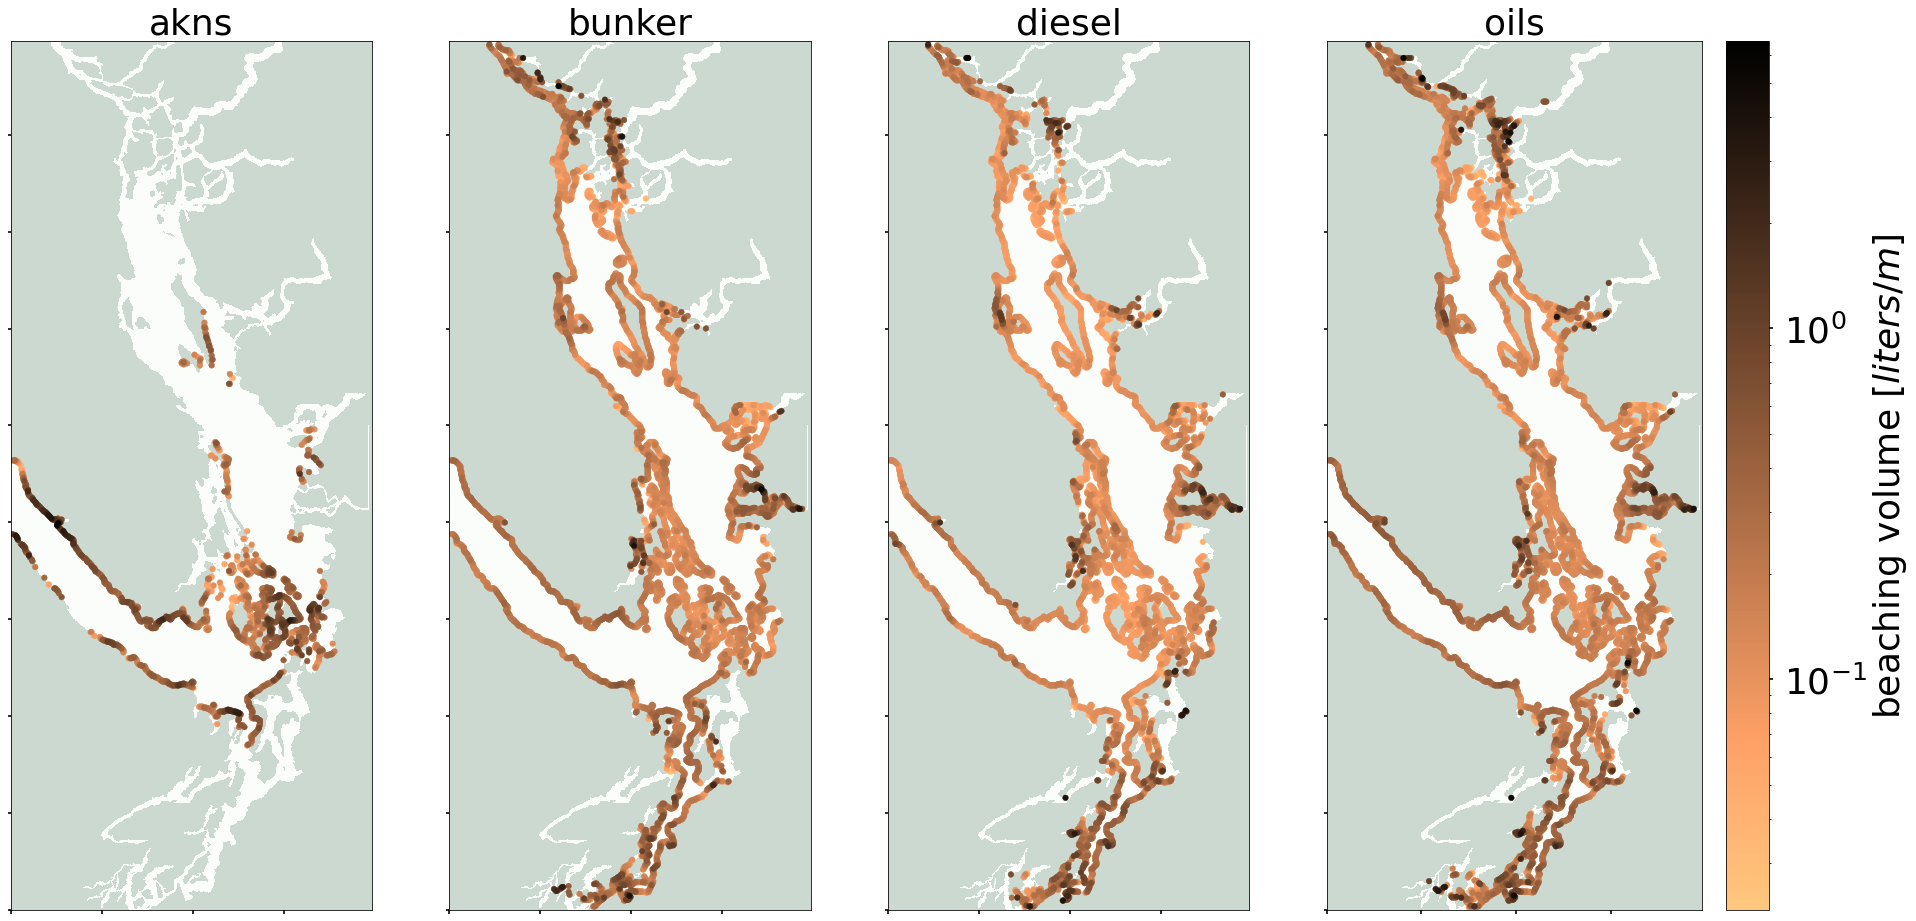

In [8]:
# set fontsize
fs = 36
oil_types = ['akns','bunker','diesel','oils']


fig, ax = plt.subplots(1,len(oil_types), figsize = (32,16),
          gridspec_kw={'width_ratios': [1 ,1, 1, 1.3]})
# Add plots for different oil types

for idx,oilname in enumerate(oil_types):
    # create dataframe for oil type
    beached_oil = np.exp(beachedoil[oilname]) * alength * 1000
    # get the x,y values in vector form
    coords=np.asarray(np.argwhere(beached_oil))
    x, y = coords[:, 0], coords[:, 1]
    # get the beached oil in vector form
    beached_oil_1d = beached_oil.compressed()
    df = pd.DataFrame(data={'x': x,
                        'y': y,
                        'z': beached_oil_1d})
    df.sort_values('z', ascending=True, inplace=True)
    # plotting the land mask
    ax[idx].pcolormesh(1.8*tmask[1:, 1:], cmap='Greens', 
                  vmin=-0.2, vmax=1.6, alpha=alpha_land)
    sc=ax[idx].scatter(df.y,df.x,c=df.z, 
                  s=32, 
                  cmap = 'copper_r',
                 norm=colors.LogNorm())
    ax[idx].set_xticklabels('')
    ax[idx].set_yticklabels('')
    ax[idx].set_title(oilname, fontsize = fs)
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax[idx])
#cax = divider.append_axes('right', size="20%", pad=0.8,)
#cbar = fig.colorbar(sc, cax=cax, orientation='vertical');
cbar = plt.colorbar(sc,orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('beaching volume [$liters/m$]', fontsize = fs);

In [9]:
beached_oil.shape

(896, 396)

## Fraction of total oil spilled

akns: 0.91 [min] - 200.04 max] 
bunker: 0.14 [min] - 16.31 max] 
diesel: 0.20 [min] - 20.09 max] 
oils: 1.00 [min] - 1.00 max] 


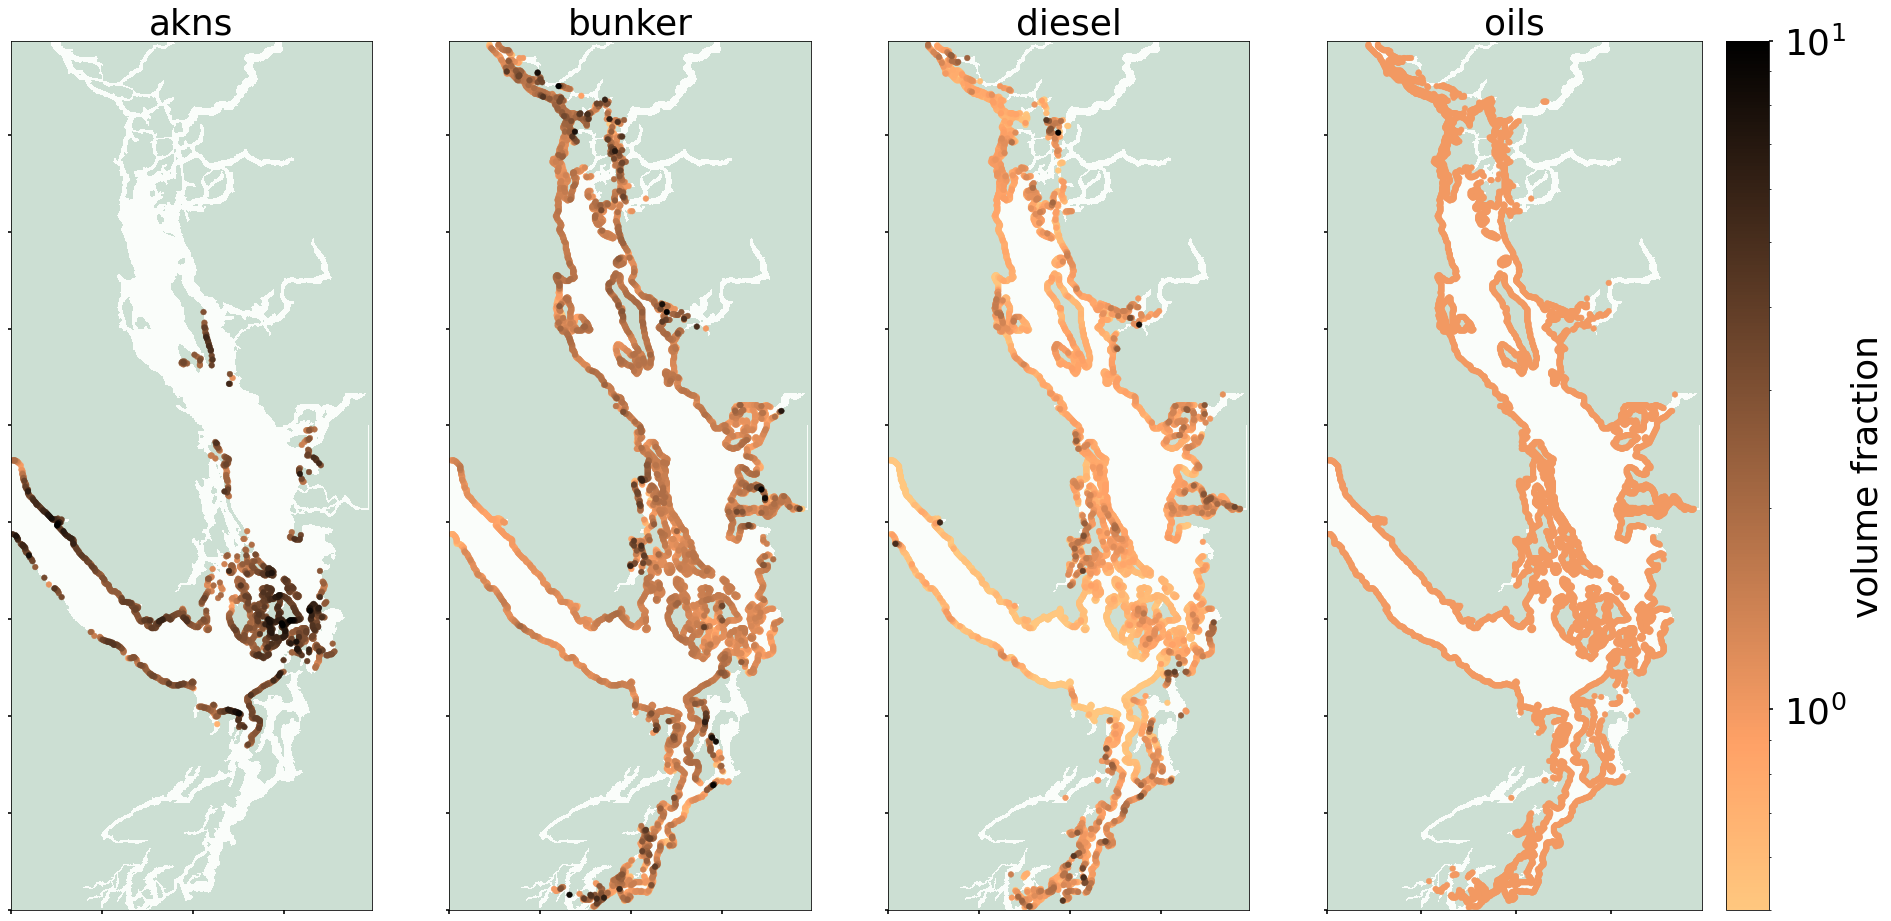

In [10]:
fig, ax = plt.subplots(1,len(oil_types), figsize = (32,16),
          gridspec_kw={'width_ratios': [1 ,1, 1, 1.3]})
# Add plots for different oil types

for idx,oilname in enumerate(oil_types):
    # create dataframe for oil type
    beached_oil = np.exp(beachedoil[oilname])/np.exp(beachedoil['oils'])
    print(f'{oilname}: {beached_oil.min():1.2f} [min] - {beached_oil.max():1.2f} max] ')
    #beached_oil = np.exp(beachedoil[oilname])
    # get the x,y values in vector form
    coords=np.asarray(np.argwhere(beached_oil))
    x, y = coords[:, 0], coords[:, 1]
    # get the beached oil in vector form
    beached_oil_1d = beached_oil.compressed()
    df = pd.DataFrame(data={'x': x,
                        'y': y,
                        'z': beached_oil_1d})
    df.sort_values('z', ascending=True, inplace=True)
    # plotting the land mask
    ax[idx].pcolormesh(1.8*tmask[1:, 1:], cmap='Greens', 
                  vmin=-0.2, vmax=2, alpha=alpha_land)
    if oilname=='akns':
        sc=ax[idx].scatter(df.y,df.x,c=df.z, 
                      s=32, 
                      cmap = 'copper_r',
                      norm=colors.LogNorm(vmin = 0.5, vmax=150)
        )
    else:
        sc=ax[idx].scatter(df.y,df.x,c=df.z, 
                      s=32, 
                      cmap = 'copper_r',
                      norm=colors.LogNorm(vmin = 0.5, vmax=10)
         )  
    ax[idx].set_xticklabels('')
    ax[idx].set_yticklabels('')
    ax[idx].set_title(oilname, fontsize = fs)
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax[idx])
# cax = divider.append_axes('right', size="20%", pad=0.8,)
#cbar = fig.colorbar(sc, cax=cax, orientation='vertical');
cbar = plt.colorbar(sc,orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('volume fraction', fontsize = fs);